
# 02 – Supervised Fraud Classification

**Module:** Anomaly & Fraud Detection  
**Folder:** Fraud Detection Workflows

This notebook demonstrates **supervised fraud detection** using labeled transactional data,
with a strong emphasis on **class imbalance handling, leakage prevention, and business-aligned evaluation**.


## Objective

Build a supervised fraud modeling workflow that:
- Learns from labeled fraud data
- Handles extreme class imbalance correctly
- Uses class-weighted and tree-based models
- Produces calibrated fraud risk scores


## Design Principles

✔ Labels treated as delayed signals  
✔ Imbalance-aware modeling  
✔ Probability-based outputs (risk scores)  
✔ Ready for threshold tuning and deployment


## Imports and Setup

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

np.random.seed(2010)

##  Simulated Fraud Dataset

In [19]:
n_rows = 6000

# Simulated features
df = pd.DataFrame({
    "log_amount": np.random.normal(3, 1, n_rows),
    "tx_count_1h": np.random.poisson(2, n_rows),
    "tx_count_24h": np.random.poisson(5, n_rows),
    "amount_sum_1h": np.random.exponential(100, n_rows),
    "amount_vs_user_mean": np.random.normal(1, 0.5, n_rows)
})

# Highly imbalanced fraud label (~1.5%)
df["is_fraud"] = (np.random.rand(n_rows) < 0.015).astype(int)

In [35]:
df.head()

,log_amount,tx_count_1h,tx_count_24h,amount_sum_1h,amount_vs_user_mean,is_fraud
0,2.894296,4,8,147.751332,1.741961,0
1,2.490703,1,3,258.166718,0.042524,0
2,3.734484,0,4,117.667634,1.491628,0
3,2.979201,1,3,55.274887,0.968212,0
4,0.583843,2,10,95.122333,0.627956,0


'''

    DATA_PATH = "D:/GitHub/Data-Science-Techniques/datasets/Anomaly-fraud-detection"
    df.to_csv(DATA_PATH + '/' + 'data', index=False)

'''

## Train / Validation Split

Stratification preserves fraud ratio

In [22]:
FEATURES = [c for c in df.columns if c != "is_fraud"]
X = df[FEATURES]
y = df["is_fraud"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

##  Baseline: Logistic Regression (Class-Weighted)

In [25]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

y_val_pred = log_reg.predict(X_val)
y_val_proba = log_reg.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))

              precision    recall  f1-score   support

           0       0.99      0.58      0.73      1778
           1       0.01      0.32      0.02        22

    accuracy                           0.57      1800
   macro avg       0.50      0.45      0.37      1800
weighted avg       0.97      0.57      0.72      1800

ROC-AUC: 0.49294406381020556


## Tree-Based Model: Random Forest (Class-Weighted)

In [27]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_val)
y_val_proba_rf = rf.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred_rf))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1778
           1       0.00      0.00      0.00        22

    accuracy                           0.99      1800
   macro avg       0.49      0.50      0.50      1800
weighted avg       0.98      0.99      0.98      1800

ROC-AUC: 0.5304734635443297


##  Feature Importance (Tree-Based)

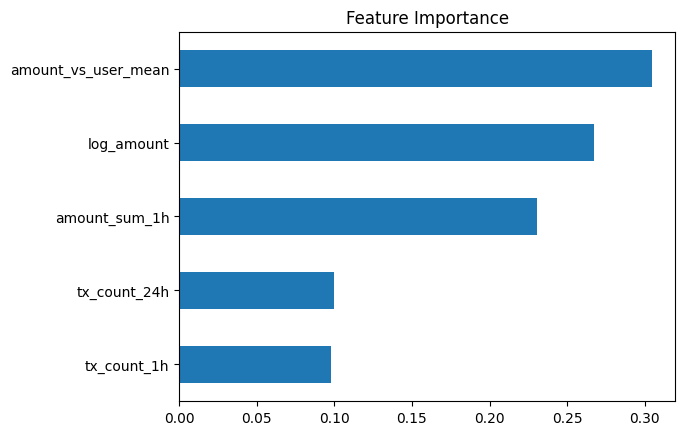

In [31]:
importances = pd.Series(rf.feature_importances_, index=FEATURES)
importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

## Risk Scores vs Hard Labels

Fraud models should output **risk probabilities**, not just binary decisions.

In [14]:
score_df = pd.DataFrame({
    "fraud_probability": y_val_proba_rf,
    "is_fraud": y_val.values
})

score_df.head()

,fraud_probability,is_fraud
0,0.315452,0
1,0.209577,0
2,0.262915,0
3,0.256334,0
4,0.273000,0


"""

    DATA_PATH = "D:/GitHub/Data-Science-Techniques/datasets/Anomaly-fraud-detection"
    score_df.to_csv(DATA_PATH + '/' + 'score_df.csv', index=False)

"""


## Integration Notes

- Supervised fraud detection relies on high-quality features  
- Class weighting is preferred over naive resampling for stability  
- Tree-based models capture non-linear fraud patterns  
- Probabilities enable threshold and cost-sensitive decisions


## Production Checklist

✔ Stratified splits  
✔ Class imbalance handled explicitly  
✔ Probabilistic outputs available  
✔ Feature importance reviewed


## Key Takeaways

- Fraud classification is a **risk scoring problem**  
- Accuracy is misleading for rare events  
- Probabilities + thresholds drive business decisions


## Next Steps

- Threshold tuning and cost-sensitive evaluation  
- Precision–Recall and PR-AUC analysis  
- Integration with anomaly detection scores